You might have noticed that the examples we used in the **Clustering** section were all in the **2-dimensional space**, i.e., the samples were described by only two variables. In reality, the samples are often described by tens of thousands of variables, or, they lie in a **high-dimensional** space. We could still go directly and run clustering on these data, but doing so is costly computationally and often times, do not perform well. Solution? **Dimensionality reduction**.

Two major types of approaches for dimensionality reduction are **feature selection** and **feature extraction**. In this notebook, we will focus on **factor analysis (FA)**, which is a linear feature extraction approach. We will cover other approaches of in Day 5.

*Most materials here are from [Introduction to Factor Analysis in Python](https://www.datacamp.com/community/tutorials/introduction-factor-analysis) and [Exploratory Factor Analysis](https://www.slideshare.net/jtneill/exploratory-factor-analysis)

## Idea of factors
Observed variables can be described as linear combinations of  unobserved factors, with each of which explains certain amount of the variance in the variables. Factor analysis tries to find a group of unobservable factors that linearly relates to the observed variables, therefore helps to reduce the number of dimensions. Meanwhile, it also serves as a way to classify variables.

<figure>
  <img src="https://res.cloudinary.com/dchysltjf/image/upload/f_auto,q_auto:best/v1554830324/6.png" width="300"  alt="factors"/>
  <figcaption>
   Variable Y as a linear combination of factor Fs. From  <a href="https://www.datacamp.com/community/tutorials/introduction-factor-analysis">Introduction to Factor Analysis in Python</a>
    </figcaption>
</figure>




## Assumptions 

1. There are no outliers in data (like outliers in a 2-variable scatterplot or high [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) in multi-variable conditions)
2. Sample size should be greater than the factor (how great? 20:1 is ideal)
3. There should be some collinearity but not **perfect multicollinearity** (i.e., two or more independent variables have an exact linear relationship between them)
4. **Homoscedasticity** between the variables are not required (a.k.a, it's fine if the variables don't have the same variance)

## Types of FA
1. **Exploratory**: any observed variable is directly associated with any factor. It explores underlying correlational structure for a data set.
2. **Confirmatory**: each factor is associated with a particular set of observed variables. It tests the correlational structure of a data set against a hypothesised structure and rates the "goodness of fit"

Today, we will focus on the Exploratory Factor Analysis (EFA). Let's go ahead and give it a try. We'll explain the process, the ways to optimize, and result interpretations along the way.

In [1]:
# install factor analysis package
!pip install factor_analyzer
# load required libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

     |████████████████████████████████| 51kB 2.9MB/s 


In [2]:
# Download BFI data (dataset based on personality assessment project)
# The site that hosts this data also hosts other cool data, feel free to check out
!wget https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv
!ls

--2019-08-03 22:44:39--  https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv
Resolving vincentarelbundock.github.io (vincentarelbundock.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to vincentarelbundock.github.io (vincentarelbundock.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182884 (179K) [text/csv]
Saving to: ‘bfi.csv’

bfi.csv             100%[===================>] 178.60K  --.-KB/s    in 0.04s   

2019-08-03 22:44:39 (4.75 MB/s) - ‘bfi.csv’ saved [182884/182884]

bfi.csv  sample_data  scRNA_widemtx.csv


In [3]:
# Let's see what we have here
# Read and save bfi data set in df
df= pd.read_csv("bfi.csv", index_col=0)
# Show the dimensions of this data
print("This data has %d rows and %d columns." % (df.shape[0], df.shape[1]))
# Show column names of df
df.columns

This data has 2800 rows and 28 columns.


Index(['A1', 'A2', 'A3', 'A4', 'A5', 'C1', 'C2', 'C3', 'C4', 'C5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'N1', 'N2', 'N3', 'N4', 'N5', 'O1', 'O2', 'O3', 'O4',
       'O5', 'gender', 'education', 'age'],
      dtype='object')

This data shows the answers of 2800 research subjects to 25 questions regarding their personalities organized by five putative factors: Agreeableness, Conscientiousness, Extraversion, Neuroticism, and Opennness. Data were collected using a 6 point response scale: 1 Very Inaccurate, 2 Moderately Inaccurate, 3 Slightly Inaccurate, 4 Slightly Accurate, 5 Moderately Accurate, 6 Very Accurate. Are these putative factors actually supported by the data?

Before we start FA, let's do some prepocessing to clear it up. Notice, there are three demographic variables included in the matrix which we don't need for FA. We'll remove them from the matrix first.

In [0]:
# Dropping unnecessary columns
df.drop(['gender', 'education', 'age'],axis=1,inplace=True)

It is quite often when research subjects missed or chose to skip question(s) in the survey. We do not want that to be included in the analysis. We'll look at each row/subject, and drop it from the matrix if any missing value was there.

In [5]:
# Dropping missing values rows
## "axis" controls whether to drop rows (0) or columns (1).
## "how" determines the criteria. Here, at least one missing value will do.
## "inplace" will allow the dropping to happen inplace, 
## so you don't need to redirect the returned matrix to a new variable.
df.dropna(axis=0, how="any", inplace=True)
print("This data has %d rows and %d columns left." % (df.shape[0], df.shape[1]))

This data has 2436 rows and 25 columns left.


## Adequacy test - the factorability
To know if our data meets the third assumption of collinearity, we need to evaluate its "factorability". Two methods we can use:

### Bartlett’s Test
Tests the hypothesis that the correlation matrix is an identity matrix. If it is, then the variables are unrelated and therefore unsuitable for the analysis. Significance shown in result would suggest overthrown of this null hypothesis, and a indication that the data is factorable ([KMO and Bartlett's Test](https://www.ibm.com/support/knowledgecenter/de/SSLVMB_24.0.0/spss/tutorials/fac_telco_kmo_01.html)).

In [6]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(18170.96635086924, 0.0)

### Kaiser-Meyer-Olkin Test
Estimates the proportion of variance among all the observed variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with your data. If the value is less than 0.50, the results of the factor analysis probably won't be very useful.


In [7]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.8485397221949221

Our data passed both tests! :tada:. We can now proceed to the analysis.

## Run FA
Key steps in FA is factor extraction and factor rotation. Extraction obtains the factors, while rotation converts factors into uncorrelated factors to improve the overall interpretability.

### Factor extraction
Each variable contains common and unique variances. Principal axis factoring approach, including Minimum Residues (MINRES) and Maximum Likelihood (ML), focuses on the common variances (the shared), while principal component approach like PCA uses all variances. Practial difference among these methods could be little, so no harm in trying all of them if desired.

In [0]:
# Create factor analysis object
## the extraction approach can be set by "method". 
## we use "principal" here. you can switch to "minres" or "ml"
fa = FactorAnalyzer(method="principal", n_factors=25, rotation=None)

How many factors should we ask the algorithm to find? For this, we can calculate the eigenvalue of each factor and drop the ones with eigenvalues below one (the Kaiser criterion) or after the "elbow point" (scree plot). 

Eigenvalues represent variance explained each factor from the total variance. It is also known as characteristic roots.

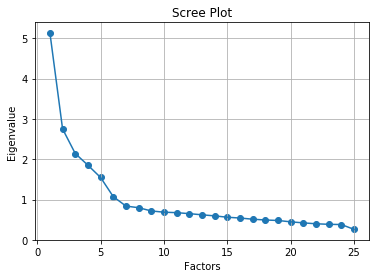

In [9]:
# perform test FA
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
# Create scree plot 
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Only the first six factors have eigenvalues over one. Let's see what would the result be if we use **six** as the number of factors for the actual analysis.



In [10]:
fa = FactorAnalyzer(method="principal", n_factors=6, rotation=None)
fa.fit(df)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=6, rotation=None,
               rotation_kwargs={}, use_smc=True)

We can check the relationship of each variable to the underlying factor by `fa.loadings_`. It shows the correlation coefficient for observed variable and factor.

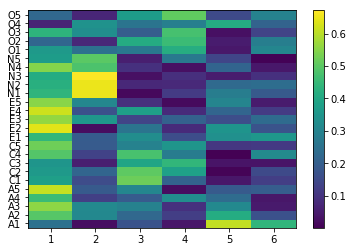

In [11]:
# save the loadings from FA fitting
loadings = pd.DataFrame(fa.loadings_, index=df.columns, columns=range(1,7))

# plot factor loadings (by column) for variables (on rows)
## absolue values of the loadings are used (ignore directions)
plt.pcolor(pd.DataFrame(abs(loadings), index=loadings.index, columns=loadings.columns))
plt.yticks(np.arange(0.5, len(loadings.index), 1), loadings.index)
plt.xticks(np.arange(0.5, len(loadings.columns), 1), loadings.columns)
plt.colorbar()
plt.show()

The relationship between variables and factors seems unclear. To make this more interpretable, we could try a **Rotation**. 

### Factor rotation
Rotation can be orthogonal or oblique. It re-distributed the commonalities with a clear pattern of loadings (commonalities: the sum of the squared loadings for each variable, representing the common variance).

The `FactorAnalyzer` we use here provides various rotation approaches: varimax (orthogonal rotation), promax (oblique rotation), oblimin (oblique rotation), oblimax (orthogonal rotation), quartimin (oblique rotation), quartimax (orthogonal rotation), equamax (orthogonal rotation). We can see what each of them do.

Run the two code chunks below, and play with the options for "Rotate by". Do you see one method that could make the relationship clearer?

In [0]:
# import modules for interactive controls
from ipywidgets import interact
import ipywidgets as widgets

In [13]:
# define a function that allow us to provide different input for factor extraction
# methods, number of factors, and factor rotation methods.
# we use the interact module to create user interface (UI) controls for 
# exploring the result of changing these parameters interactively.
def fa_rotation_tester(method, n_factors, rotation):
  fa = FactorAnalyzer(method=method, n_factors=n_factors, rotation=rotation)
  fa.fit(df)
  # save the loadings from FA fitting
  loadings = pd.DataFrame(fa.loadings_, index=df.columns, columns=range(1,n_factors + 1))

  # plot factor loadings (by column) for variables (on rows)
  ## absolue values of the loadings are used (ignore directions)
  plt.pcolor(pd.DataFrame(abs(loadings), index=loadings.index, columns=loadings.columns))
  plt.yticks(np.arange(0.5, len(loadings.index), 1), loadings.index)
  plt.xticks(np.arange(0.5, len(loadings.columns), 1), loadings.columns)
  plt.colorbar()
  plt.show()
  return

interact(fa_rotation_tester,
         method = widgets.Dropdown(options=['principal', 'minres', 'ml'],
                                   value='principal',
                                   description='Extract by: '),
         n_factors = widgets.IntSlider(value=6,
                                       min=1,
                                       max=6,
                                       step=1,
                                       description='Numfactors: '),
         rotation = widgets.Dropdown(options=[None,'varimax','promax','oblimin','oblimax','quartimin','quartimax','equamax'],
                                     value=None,
                                     description='Rotate by: '))


interactive(children=(Dropdown(description='Extract by: ', options=('principal', 'minres', 'ml'), value='princ…

<function __main__.fa_rotation_tester>

WIth rotation added, the relationship do clear up a lot. But, notice that 5th and 6th factors are still not as interpretable as the first four factors. Maybe try five factors instead?

In [14]:
# Pick your favorite parameter set and see how much variance could
# the resulting factors explain
pd.DataFrame(fa.get_factor_variance(), 
             index=['variance','proportional_var','cumulative_var'],
             columns=loadings.columns)


,1,2,3,4,5,6
variance,5.134311,2.751887,2.142702,1.852327,1.548161,1.073288
proportional_var,0.205372,0.110075,0.085708,0.074093,0.061926,0.042932
cumulative_var,0.205372,0.315448,0.401156,0.475249,0.537176,0.580107


## FA vs. PCA?
It is confusing when we talk about FA by itself when both FA and PCA are used for data dimensionality reduction, go through the same procedures of extraction, choosing the right number of components, rotation, and even the result looks pretty much the same. So what's the difference?

PCA is a linear combination of variables, while Factor Analysis is a measurement model of a latent variable (from [The Fundamental Difference Between Principal Component Analysis and Factor Analysis](https://www.theanalysisfactor.com/the-fundamental-difference-between-principal-component-analysis-and-factor-analysis/)). Let's compare the scenarios where we have only one component for PCA and one factor for FA.

<figure>
  <img src="https://i2.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/09/KGM_Sept2016_Image1.png?zoom=2&resize=383%2C314" width="400"  alt="PCA components"/>
  <figcaption>
   PCA: combining variables (Y) into a component (C).
    </figcaption>
  <img src="https://i1.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/09/KGM_Sept2016_Image2.png?zoom=2&resize=383%2C235" width="400" alt="FA factors"/>
  <figcaption>
    FA: Factor (F) causes the responses on the four measured variables (Y). Errors unexplained by factors arer designated by the u's. From <a href="https://www.theanalysisfactor.com/the-fundamental-difference-between-principal-component-analysis-and-factor-analysis/">here</a>.
   </figcaption>
</figure>

## Take-home messages

* FA is a great tool for finding interlinked correlations in large datasets. 
* Test adequacy beforing running FA on your data
* Choose a method for factor extraction and factor rotation that works
* Find number of factors to use based on variances explained. Visit this number again when you see the interpretation does not make sense
* Take cautions for interpretation. Same factor could develop into different stories. 

